In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from utils import getStats, getStats_static, tensorize_normalize_extract_feature
import torch

# Set the path to the P19 dataset
base_path = 'data/P19'
split_path = '/splits/phy19_split1_new.npy'

# Load P19 data
print("Loading P19 dataset...")
Pdict_list = np.load(base_path + '/processed_data/PT_dict_list_6.npy', allow_pickle=True)
arr_outcomes = np.load(base_path + '/processed_data/arr_outcomes_6.npy', allow_pickle=True)

# Get train/val/test split
idx_train, idx_val, idx_test = np.load(base_path + split_path, allow_pickle=True)
print(f"Split sizes - Train: {len(idx_train)}, Val: {len(idx_val)}, Test: {len(idx_test)}")

# Extract train/val/test examples
Ptrain = Pdict_list[idx_train]
Pval = Pdict_list[idx_val]
Ptest = Pdict_list[idx_test]
y = arr_outcomes[:, -1].reshape((-1, 1))
ytrain = y[idx_train]
yval = y[idx_val]
ytest = y[idx_test]


Loading P19 dataset...
Split sizes - Train: 31042, Val: 3880, Test: 3881


In [50]:
y.shape

(38803, 1)

In [52]:
Ptrain[0]

{'id': 'Data_physionet19/trainingB\\p115711.psv',
 'length': 18,
 'extended_static': (65.0, 1.0, 0.0, 1.0, -611.84, 1.0),
 'arr': array([[  0. ,   0. ,   0. , ...,   0. ,   0. ,   0. ],
        [ 96. ,  96. ,   0. , ...,   2.3,   0. ,  15. ],
        [114. ,  96. ,   0. , ...,   0. ,   0. ,   0. ],
        ...,
        [  0. ,   0. ,   0. , ...,   0. ,   0. ,   0. ],
        [  0. ,   0. ,   0. , ...,   0. ,   0. ,   0. ],
        [  0. ,   0. ,   0. , ...,   0. ,   0. ,   0. ]]),
 'time': array([[ 1.],
        [ 2.],
        [ 3.],
        [ 4.],
        [ 5.],
        [ 6.],
        [ 7.],
        [ 8.],
        [ 9.],
        [10.],
        [11.],
        [12.],
        [13.],
        [14.],
        [15.],
        [16.],
        [17.],
        [18.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0.],
        [ 0

In [44]:
Pdict_list[2]['time'][:,0]

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 43., 44., 45., 46., 47., 48.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [45]:
Ptrain[2]['time'][:,0]

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [5]:

# Examine the structure of a single example
print("\nExamining structure of a single example...")
example = Ptrain[0]
print("Keys in each example:", list(example.keys()))

# Display shape of time series data
T, F = example['arr'].shape
print(f"Time series shape: {T} timestamps x {F} features")
print(f"Static features length: {len(example['extended_static'])}")

# Print the static feature values
print("\nStatic feature values for first example:")
print(example['extended_static'])


# Count number of observations per class
class_0_count = np.sum(y == 0)
class_1_count = np.sum(y == 1)
print(f"\nClass distribution - Class 0: {class_0_count}, Class 1: {class_1_count}")



Examining structure of a single example...
Keys in each example: ['id', 'length', 'extended_static', 'arr', 'time']
Time series shape: 60 timestamps x 34 features
Static features length: 6

Static feature values for first example:
(65.0, 1.0, 0.0, 1.0, -611.84, 1.0)


array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [15]:

# Examine the time information
print("\nTime information for first example:")
print(f"Length: {example['length']}")
print(f"Time values shape: {example['time'].shape}")
print(f"Time values (first 10): {example['time'][:10]}")

# Create tensors for training set
print("\nCreating tensors for model input...")
Ptrain_tensor = np.zeros((len(Ptrain), T, F))
Ptrain_static_tensor = np.zeros((len(Ptrain), len(example['extended_static'])))

for i in range(len(Ptrain)):
    Ptrain_tensor[i] = Ptrain[i]['arr']
    Ptrain_static_tensor[i] = Ptrain[i]['extended_static']



Time information for first example:
Length: 18
Time values shape: (60, 1)
Time values (first 10): [[ 1.]
 [ 2.]
 [ 3.]
 [ 4.]
 [ 5.]
 [ 6.]
 [ 7.]
 [ 8.]
 [ 9.]
 [10.]]

Creating tensors for model input...


In [16]:

# Calculate statistics for normalization
print("Calculating normalization statistics...")
mf, stdf = getStats(Ptrain_tensor)
ms, ss = getStats_static(Ptrain_static_tensor, dataset='P19')

# Print feature statistics
print("\nFeature statistics (first 5 features):")
for i in range(min(5, F)):
    print(f"Feature {i}: mean = {mf[i][0]:.4f}, std = {stdf[i][0]:.4f}")

print("\nStatic feature statistics:")
for i in range(len(example['extended_static'])):
    print(f"Static feature {i}: mean = {ms[i][0]:.4f}, std = {ss[i][0]:.4f}")

# Normalize and extract features
print("\nNormalizing and extracting features...")
Ptrain_tensor, Ptrain_static_tensor, Ptrain_avg_interval_tensor, \
    Ptrain_length_tensor, Ptrain_time_tensor, ytrain_tensor \
    = tensorize_normalize_extract_feature(Ptrain, ytrain, mf, stdf, ms, ss)

# Examine the processed tensors
print("\nProcessed tensor shapes:")
print(f"P_tensor: {Ptrain_tensor.shape}")
print(f"P_static_tensor: {Ptrain_static_tensor.shape}")
print(f"P_avg_interval_tensor: {Ptrain_avg_interval_tensor.shape}")
print(f"P_length_tensor: {Ptrain_length_tensor.shape}")
print(f"P_time_tensor: {Ptrain_time_tensor.shape}")


Calculating normalization statistics...

Feature statistics (first 5 features):
Feature 0: mean = 84.0971, std = 17.1150
Feature 1: mean = 97.1718, std = 2.9208
Feature 2: mean = 36.9627, std = 0.7559
Feature 3: mean = 123.5587, std = 23.0288
Feature 4: mean = 82.2957, std = 16.3526

Static feature statistics:
Static feature 0: mean = 61.6988, std = 16.4920
Static feature 1: mean = 0.0000, std = 1.0000
Static feature 2: mean = 1.0000, std = 0.0000
Static feature 3: mean = 1.0000, std = 0.0000
Static feature 4: mean = 2.1906, std = 2.8796
Static feature 5: mean = 1.5376, std = 3.1135

Normalizing and extracting features...

Processed tensor shapes:
P_tensor: torch.Size([31042, 60, 68])
P_static_tensor: torch.Size([31042, 6])
P_avg_interval_tensor: torch.Size([31042, 60, 34])
P_length_tensor: torch.Size([31042, 1])
P_time_tensor: torch.Size([31042, 60, 34])


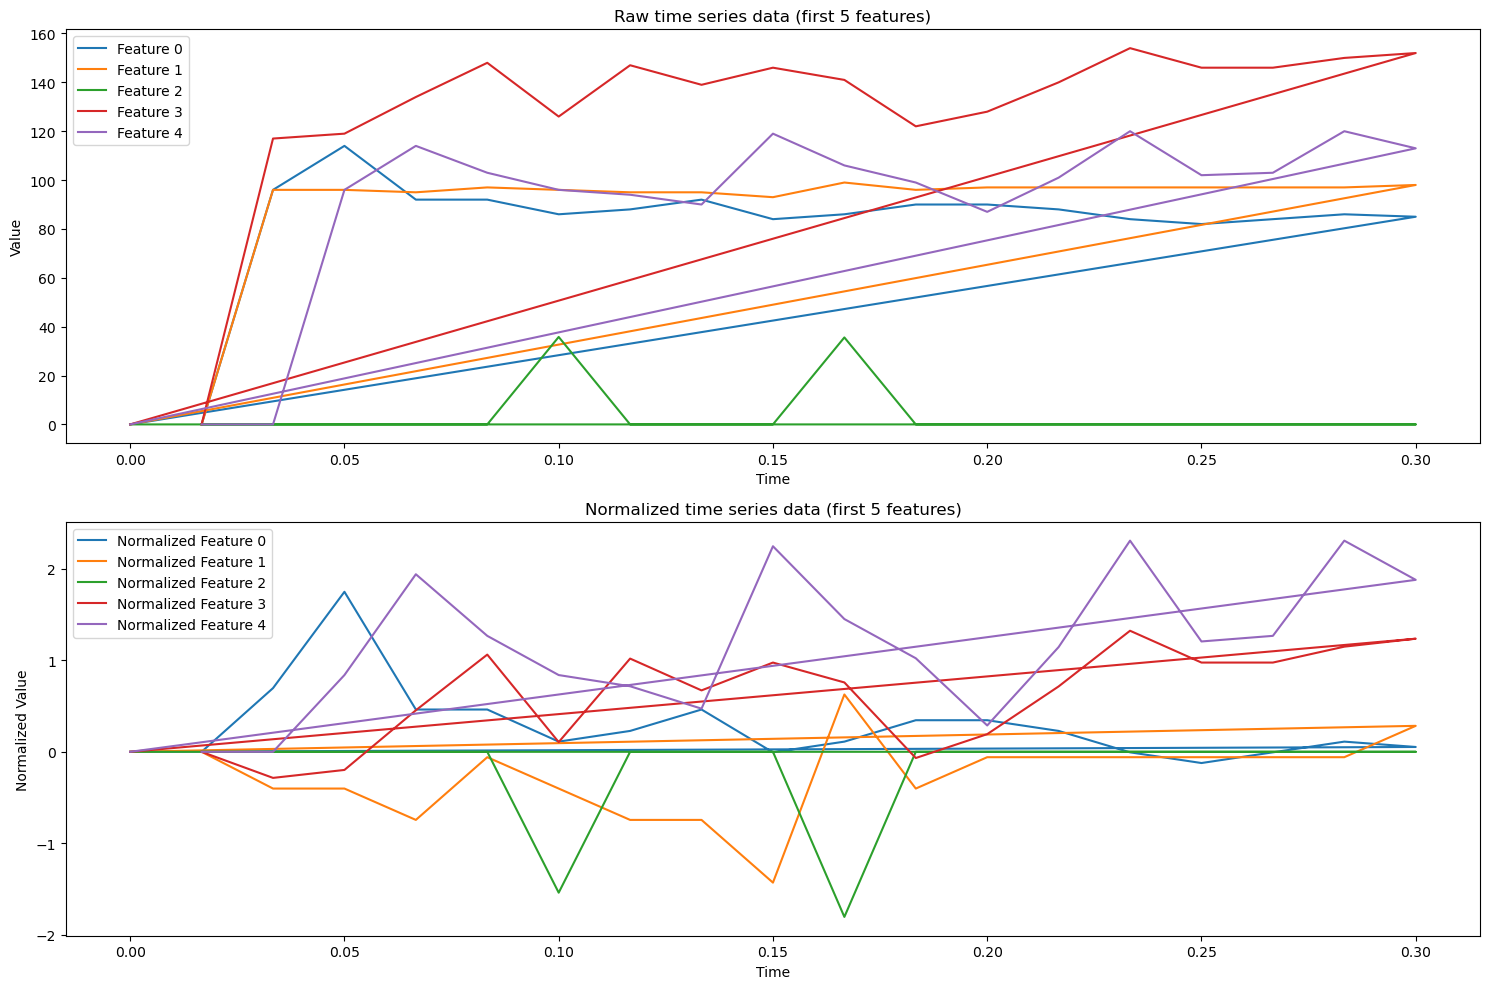

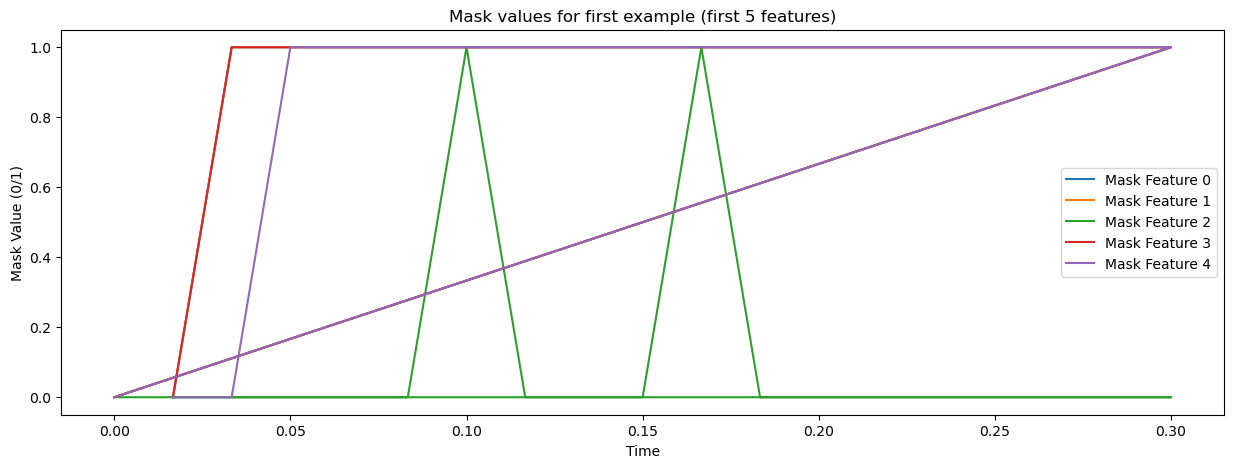

In [19]:

# Visualize a sample of the time series data
plt.figure(figsize=(15, 10))
example_idx = 0  # First example

# Before normalization
plt.subplot(2, 1, 1)
plt.title("Raw time series data (first 5 features)")
for i in range(min(5, F)):
    plt.plot(Ptrain[example_idx]['time'], Ptrain[example_idx]['arr'][:, i], 
             label=f"Feature {i}")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()

# After normalization (first half of features are normalized values, second half are masks)
plt.subplot(2, 1, 2)
plt.title("Normalized time series data (first 5 features)")
for i in range(min(5, F)):
    plt.plot(Ptrain[example_idx]['time'], Ptrain_tensor[example_idx, :, i], 
             label=f"Normalized Feature {i}")
plt.xlabel("Time")
plt.ylabel("Normalized Value")
plt.legend()

plt.tight_layout()
#plt.savefig("p19_data_visualization.png")
#print("\nVisualization saved as 'p19_data_visualization.png'")

# Visualize the mask values for the first example
plt.figure(figsize=(15, 5))
plt.title("Mask values for first example (first 5 features)")
for i in range(min(5, F)):
    plt.plot(Ptrain[example_idx]['time'], Ptrain_tensor[example_idx, :, i+F], 
             label=f"Mask Feature {i}")
plt.xlabel("Time")
plt.ylabel("Mask Value (0/1)")
plt.legend()
#plt.savefig("p19_mask_visualization.png")
#print("Mask visualization saved as 'p19_mask_visualization.png'")



Analysis complete!


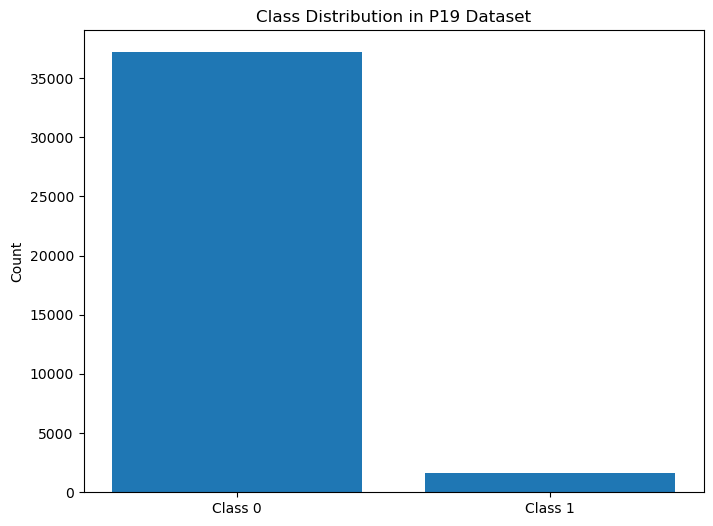

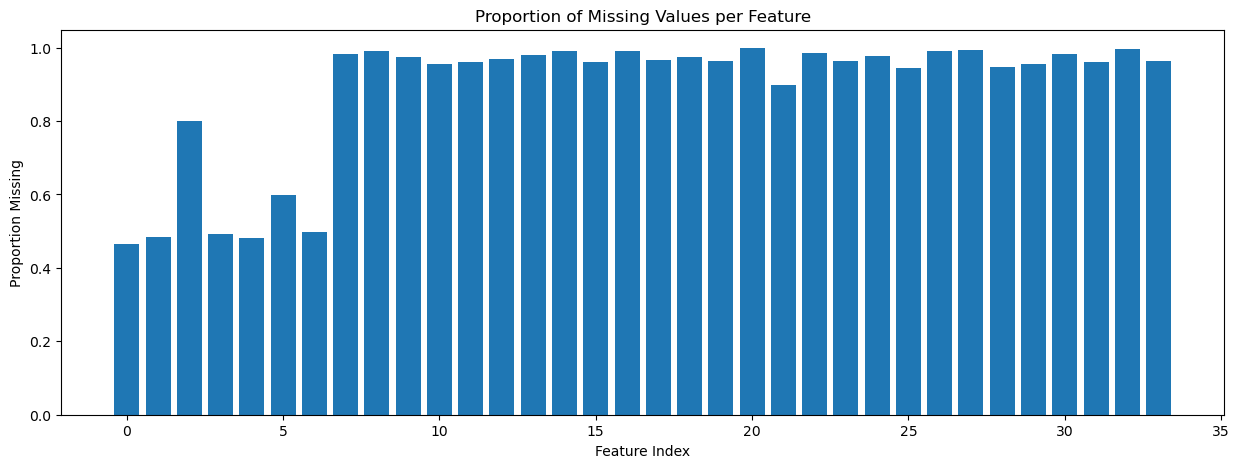

In [20]:

# Visualize the class distribution
plt.figure(figsize=(8, 6))
plt.bar(['Class 0', 'Class 1'], [class_0_count, class_1_count])
plt.title("Class Distribution in P19 Dataset")
plt.ylabel("Count")
#plt.savefig("p19_class_distribution.png")
#print("Class distribution visualization saved as 'p19_class_distribution.png'")

# Analyze missing values
missing_values = np.zeros(F)
for i in range(len(Ptrain)):
    # Convert PyTorch tensor to NumPy array before operations
    mask = Ptrain_tensor[i, :, F:2*F].numpy() if torch.is_tensor(Ptrain_tensor) else Ptrain_tensor[i, :, F:2*F]
    missing_values += np.sum(mask == 0, axis=0) / mask.shape[0]
missing_values /= len(Ptrain)

plt.figure(figsize=(15, 5))
plt.bar(range(F), missing_values)
plt.title("Proportion of Missing Values per Feature")
plt.xlabel("Feature Index")
plt.ylabel("Proportion Missing")
#plt.savefig("p19_missing_values.png")
#print("Missing values visualization saved as 'p19_missing_values.png'")

print("\nAnalysis complete!") 

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
import torch
from utils import getStats, getStats_static, tensorize_normalize_extract_feature

# Set the path to the physionet dataset
base_path = 'data/physionet'
split_path = '/splits/phy12_split5.npy'

# Load physionet data
print("Loading physionet dataset...")
Pdict_list = np.load(base_path + '/processed_data/PTdict_list.npy', allow_pickle=True)
arr_outcomes = np.load(base_path + '/processed_data/arr_outcomes.npy', allow_pickle=True)

# Get train/val/test split
idx_train, idx_val, idx_test = np.load(base_path + split_path, allow_pickle=True)
print(f"Split sizes - Train: {len(idx_train)}, Val: {len(idx_val)}, Test: {len(idx_test)}")

# Extract train/val/test examples
Ptrain = Pdict_list[idx_train]
Pval = Pdict_list[idx_val]
Ptest = Pdict_list[idx_test]
y = arr_outcomes[:, -1].reshape((-1, 1))
ytrain = y[idx_train]
yval = y[idx_val]
ytest = y[idx_test]

# Examine the structure of a single example
print("\nExamining structure of a single example...")
example = Ptrain[0]
print("Keys in each example:", list(example.keys()))

# Display shape of time series data
T, F = example['arr'].shape
print(f"Time series shape: {T} timestamps x {F} features")
print(f"Static features length: {len(example['extended_static'])}")

# Print the static feature values
print("\nStatic feature values for first example:")
print(example['extended_static'])

# Count number of observations per class
class_0_count = np.sum(y == 0)
class_1_count = np.sum(y == 1)
print(f"\nClass distribution - Class 0: {class_0_count}, Class 1: {class_1_count}")

# Examine the time information
print("\nTime information for first example:")
print(f"Length: {example['length']}")
print(f"Time values shape: {example['time'].shape}")
print(f"Time values (first 10): {example['time'][:10]}")


Loading physionet dataset...


FileNotFoundError: [Errno 2] No such file or directory: 'data/physionet/processed_data/PTdict_list.npy'

In [ ]:

# Create tensors for training set
print("\nCreating tensors for model input...")
Ptrain_tensor = np.zeros((len(Ptrain), T, F))
Ptrain_static_tensor = np.zeros((len(Ptrain), len(example['extended_static'])))

for i in range(len(Ptrain)):
    Ptrain_tensor[i] = Ptrain[i]['arr']
    Ptrain_static_tensor[i] = Ptrain[i]['extended_static']

# Calculate statistics for normalization
print("Calculating normalization statistics...")
mf, stdf = getStats(Ptrain_tensor)
ms, ss = getStats_static(Ptrain_static_tensor, dataset='physionet')

# Print feature statistics
print("\nFeature statistics (first 5 features):")
for i in range(min(5, F)):
    print(f"Feature {i}: mean = {mf[i][0]:.4f}, std = {stdf[i][0]:.4f}")

print("\nStatic feature statistics:")
for i in range(len(example['extended_static'])):
    print(f"Static feature {i}: mean = {ms[i][0]:.4f}, std = {ss[i][0]:.4f}")

# Normalize and extract features
print("\nNormalizing and extracting features...")
Ptrain_tensor, Ptrain_static_tensor, Ptrain_avg_interval_tensor, \
    Ptrain_length_tensor, Ptrain_time_tensor, ytrain_tensor \
    = tensorize_normalize_extract_feature(Ptrain, ytrain, mf, stdf, ms, ss)

# Examine the processed tensors
print("\nProcessed tensor shapes:")
print(f"P_tensor: {Ptrain_tensor.shape}")
print(f"P_static_tensor: {Ptrain_static_tensor.shape}")
print(f"P_avg_interval_tensor: {Ptrain_avg_interval_tensor.shape}")
print(f"P_length_tensor: {Ptrain_length_tensor.shape}")
print(f"P_time_tensor: {Ptrain_time_tensor.shape}")

# Visualize a sample of the time series data
plt.figure(figsize=(15, 10))
example_idx = 0  # First example

# Before normalization
plt.subplot(2, 1, 1)
plt.title("Raw time series data (first 5 features)")
for i in range(min(5, F)):
    plt.plot(Ptrain[example_idx]['time'], Ptrain[example_idx]['arr'][:, i], 
             label=f"Feature {i}")
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()

# After normalization (first half of features are normalized values, second half are masks)
plt.subplot(2, 1, 2)
plt.title("Normalized time series data (first 5 features)")
for i in range(min(5, F)):
    # Convert to numpy if tensor
    norm_data = Ptrain_tensor[example_idx, :, i].numpy() if torch.is_tensor(Ptrain_tensor) else Ptrain_tensor[example_idx, :, i]
    plt.plot(Ptrain[example_idx]['time'], norm_data, 
             label=f"Normalized Feature {i}")
plt.xlabel("Time")
plt.ylabel("Normalized Value")
plt.legend()

plt.tight_layout()
plt.savefig("physionet_data_visualization.png")
print("\nVisualization saved as 'physionet_data_visualization.png'")

# Visualize the mask values for the first example
plt.figure(figsize=(15, 5))
plt.title("Mask values for first example (first 5 features)")
for i in range(min(5, F)):
    # Convert to numpy if tensor
    mask_data = Ptrain_tensor[example_idx, :, i+F].numpy() if torch.is_tensor(Ptrain_tensor) else Ptrain_tensor[example_idx, :, i+F]
    plt.plot(Ptrain[example_idx]['time'], mask_data, 
             label=f"Mask Feature {i}")
plt.xlabel("Time")
plt.ylabel("Mask Value (0/1)")
plt.legend()
plt.savefig("physionet_mask_visualization.png")
print("Mask visualization saved as 'physionet_mask_visualization.png'")

# Visualize the class distribution
plt.figure(figsize=(8, 6))
plt.bar(['Class 0', 'Class 1'], [class_0_count, class_1_count])
plt.title("Class Distribution in Physionet Dataset")
plt.ylabel("Count")
plt.savefig("physionet_class_distribution.png")
print("Class distribution visualization saved as 'physionet_class_distribution.png'")

# Analyze missing values
missing_values = np.zeros(F)
for i in range(len(Ptrain)):
    # Convert PyTorch tensor to NumPy array before operations
    mask = Ptrain_tensor[i, :, F:2*F].numpy() if torch.is_tensor(Ptrain_tensor) else Ptrain_tensor[i, :, F:2*F]
    missing_values += np.sum(mask == 0, axis=0) / mask.shape[0]
missing_values /= len(Ptrain)

plt.figure(figsize=(15, 5))
plt.bar(range(F), missing_values)
plt.title("Proportion of Missing Values per Feature")
plt.xlabel("Feature Index")
plt.ylabel("Proportion Missing")
plt.savefig("physionet_missing_values.png")
print("Missing values visualization saved as 'physionet_missing_values.png'")

# Add more detailed visualization comparing static features across patients
plt.figure(figsize=(15, 5))
static_features = ['Age', 'Gender=0', 'Gender=1', 'Height', 'ICUType=1', 'ICUType=2', 'ICUType=3', 'ICUType=4', 'Weight']
static_means = np.mean(Ptrain_static_tensor.numpy() if torch.is_tensor(Ptrain_static_tensor) else Ptrain_static_tensor, axis=0)
plt.bar(static_features, static_means)
plt.title("Average Values of Static Features")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("physionet_static_features.png")
print("Static features visualization saved as 'physionet_static_features.png'")

print("\nAnalysis complete!") 